In [ ]:
#Importo las liberías necesarias
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler


rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]

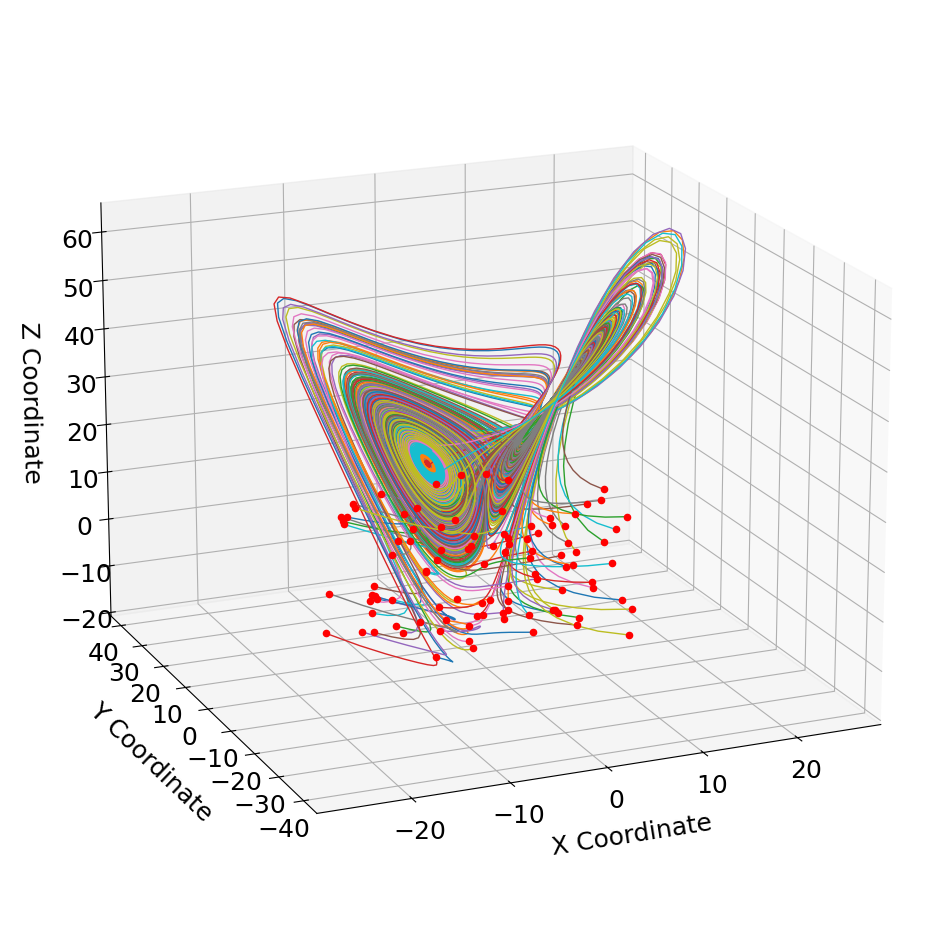

In [ ]:
#Simulación del sistema
dt=0.01
T=8
t=np.arange(0,T+dt,dt)
beta=8/3
sigma=10
rho=28

nn_input=np.zeros((100*(len(t)-1),3))
nn_output=np.zeros_like(nn_input)

fig,ax=plt.subplots(1,1,subplot_kw={'projection':'3d'})

def lorenz_deriv(x_y_z,t0,sigma=sigma,beta=beta,rho=rho):
    x,y,z=x_y_z
    return [sigma*(y-x),x*(rho-z)-y,x*y-beta*z]

np.random.seed(123)
x0=-15+30*np.random.random((100,3))

x_t=np.asarray([integrate.odeint(lorenz_deriv,x0_j,t)
                  for x0_j in x0])

for j in range(100):
    nn_input[j*(len(t)-1):(j+1)*(len(t)-1),:]=x_t[j,:-1,:]
    nn_output[j*(len(t)-1):(j+1)*(len(t)-1),:]=x_t[j,1:,:]
    x,y,z=x_t[j,:,:].T
    ax.plot(x,y,z,linewidth=1)
    ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')

ax.view_init(18,-113)
ax.set_xlabel('X Coordinate',labelpad=15)
ax.set_ylabel('Y Coordinate',labelpad=15)
ax.set_zlabel('Z Coordinate',labelpad=15)
plt.show()

In [ ]:
x_train,y_train= x_t[:70,:-1], x_t[:70,1:]
x_eval,y_eval=x_t[70:80,:-1], x_t[70:80,1:]
x_test,y_test=x_t[80:,:-1], x_t[80:,1:]

#Guardo los datos de y_test para poder hacer comprobaciones
y_comprobacion=y_test

#Normalizo los datos para facilitar el entrenamiento
scaler=StandardScaler()
x_train_1=scaler.fit_transform(x_train.reshape(-1,3)).reshape(x_train.shape)
x_eval_1=scaler.transform(x_eval.reshape(-1,3)).reshape(x_eval.shape)
x_test_1=scaler.transform(x_test.reshape(-1,3)).reshape(x_test.shape)

scaler_y=StandardScaler()
y_train_1=scaler_y.fit_transform(y_train.reshape(-1,3)).reshape(y_train.shape)
y_eval_1=scaler_y.transform(y_eval.reshape(-1,3)).reshape(y_eval.shape)
y_test_1=scaler_y.transform(y_test.reshape(-1,3)).reshape(y_test.shape)

#Convierto los datos a tensores
x_train_1=torch.tensor(x_train_1,dtype=torch.float32)
y_train_1=torch.tensor(y_train_1,dtype=torch.float32)
x_test_1=torch.tensor(x_test_1,dtype=torch.float32)
y_test_1=torch.tensor(y_test_1,dtype=torch.float32)
x_eval_1=torch.tensor(x_eval_1,dtype=torch.float32)
y_eval_1=torch.tensor(y_eval_1,dtype=torch.float32)

#Guardo las dimensiones originales
y_dimension=y_test_1.size()

In [ ]:
#Defino la función de entrenamiento y evaluación de mi primer modelo

#Defino la función de pérdida
loss_function_1=nn.MSELoss()

#Función para el entrenamiento
def entrenamiento(epocas,red,optimizador,X_train,Y_train):
  #Inicializo el train del sistema
  red.train()
  #Defino una variable para guardar la pérdida del sistema
  loss_total=0.0
  #Inicilizo a 0 los gradientes del sistema
  optimizador.zero_grad()
  #Introducimos los datos de entrenamiento al modelo
  resultados=red(X_train)
  #Ahora calculo la pérdida del sistema
  loss_total=loss_function_1(resultados,Y_train)
  #Renovamos los parámetros de optimización
  loss_total.backward()
  optimizador.step()
  loss_fin_1=loss_total.item()
  #Ahora escribo en pantalla la época y la pérdida
  print(f"Training, Epoch: {epocas+1}, Loss={loss_total}")
  num_epoca_ent=epocas+1
  return loss_fin_1,num_epoca_ent

#Defino la función de evaluación del sistema

def evaluacion(epocas,red,X_eval,Y_eval):
  #Inicializo el modo de evaluación del modelo
  red.eval()
  #Defino una variable para guardar la pérdida del sistema
  loss_total_2=0.0
  #Hago que el proceso de evaluación no actualice los gradientes inecesariamente
  with torch.no_grad():
    #Introducimos los datos de evaluación al modelo
    resultados_2=red(X_eval)
    #Calculo el error asociado
    loss_total_2=loss_function_1(resultados_2,Y_eval)
    loss_fin_2=loss_total_2.item()
  #Escribo en pantalla la época y la pérdida
  print(f"Evaluation, Epoch:{epocas+1}, Loss={loss_total_2}")
  #num_epoca_eval=epocas+1
  return loss_fin_2


In [ ]:
#En primer lugar planteo la red neuronal feedforward

#Genero mi red neuronal por medio de una clase

class modelo_1(nn.Module):
  def __init__(self):
    super(modelo_1, self).__init__()
    #Comienzo a añadir las capas de mi red
    self.fc1=nn.Linear(3,62)
    self.act1=nn.ReLU()
    self.fc2=nn.Linear(62,62)
    self.act2=nn.ReLU()
    self.fc3=nn.Linear(62,62)
    self.act3=nn.ReLU()
    self.fc5=nn.Linear(62,3)

  def forward(self,x):
    x=self.fc1(x)
    x=self.act1(x)
    x=self.fc2(x)
    x=self.act2(x)
    x=self.fc3(x)
    x=self.act3(x)
    x=self.fc5(x)
    return x

red_neuronal=modelo_1()

In [ ]:
#Entreno nuestro primer modelo

#Primero lo voy a entrenar
epoca_1=100

#Genero tuplas dónde guardar las pérdidas
loss_ent_1=[]
loss_eval_1=[]
epocas_1=[]

#Optimizador
optimizador_1=optim.Adam(red_neuronal.parameters(),lr=0.002)

for i in range(epoca_1):
  perdida_1,num_epoca_1=entrenamiento(i,red_neuronal,optimizador_1,x_train_1,y_train_1)
  perdida_2=evaluacion(i,red_neuronal,x_eval_1,y_eval_1)
  #Añado los valores a las tuplas
  loss_ent_1.append(perdida_1)
  loss_eval_1.append(perdida_2)
  epocas_1.append(num_epoca_1)

Training, Epoch: 1, Loss=1.001916527748108
Evaluation, Epoch:1, Loss=0.9325273633003235
Training, Epoch: 2, Loss=0.9569991827011108
Evaluation, Epoch:2, Loss=0.8896088600158691
Training, Epoch: 3, Loss=0.9124370217323303
Evaluation, Epoch:3, Loss=0.8459532260894775
Training, Epoch: 4, Loss=0.8672175407409668
Evaluation, Epoch:4, Loss=0.8008309006690979
Training, Epoch: 5, Loss=0.8205017447471619
Evaluation, Epoch:5, Loss=0.7523084282875061
Training, Epoch: 6, Loss=0.7704290151596069
Evaluation, Epoch:6, Loss=0.6995022892951965
Training, Epoch: 7, Loss=0.7160825133323669
Evaluation, Epoch:7, Loss=0.6420551538467407
Training, Epoch: 8, Loss=0.6571126580238342
Evaluation, Epoch:8, Loss=0.5798540711402893
Training, Epoch: 9, Loss=0.5936909914016724
Evaluation, Epoch:9, Loss=0.5137581825256348
Training, Epoch: 10, Loss=0.5265700817108154
Evaluation, Epoch:10, Loss=0.4451845586299896
Training, Epoch: 11, Loss=0.4571172893047333
Evaluation, Epoch:11, Loss=0.37615787982940674
Training, Epoch: 

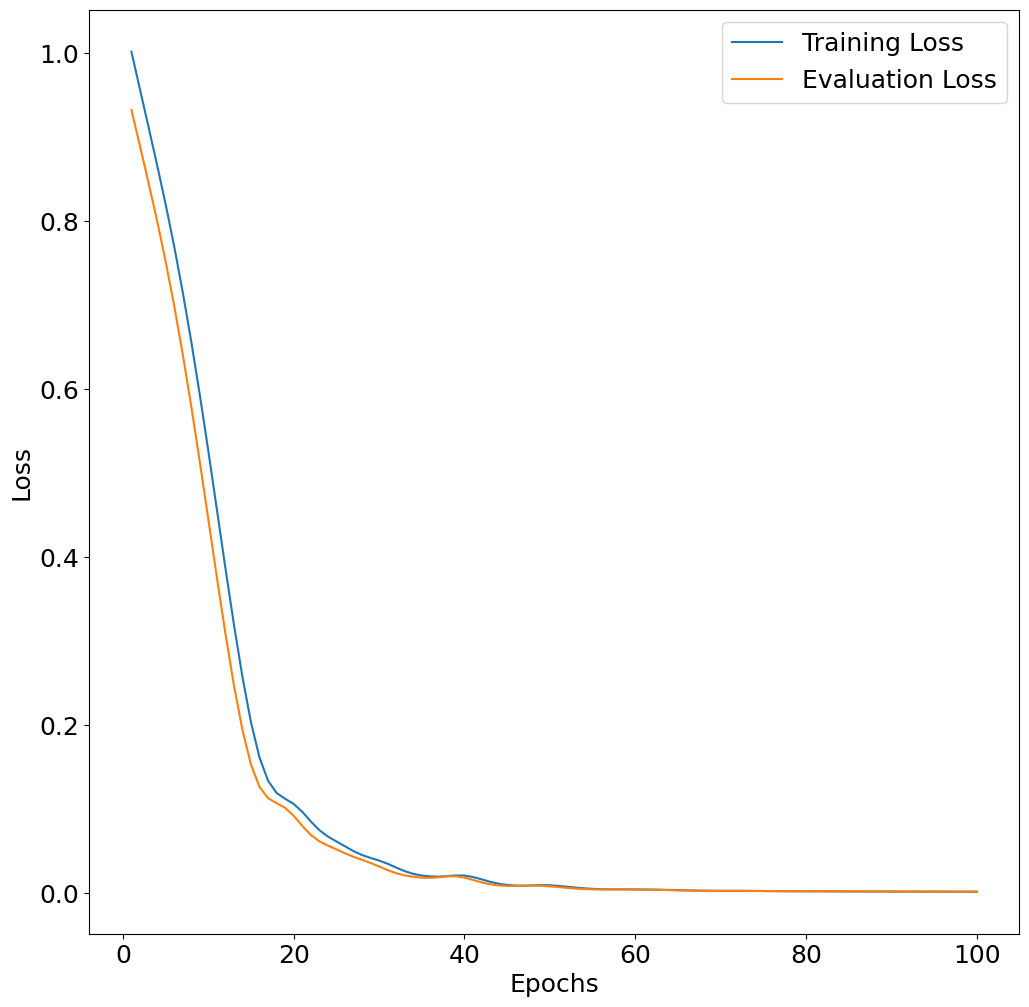

In [ ]:
#Dibujo las funciones de pérdida del entrenamiento y la evaluación

#Hago el plot

plt.plot(epocas_1,loss_ent_1,label='Training Loss')        #Plot para la pérdida del entrenamiento
plt.plot(epocas_1,loss_eval_1,label='Evaluation Loss')     #Plot para la pérdida de la evaluacion
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

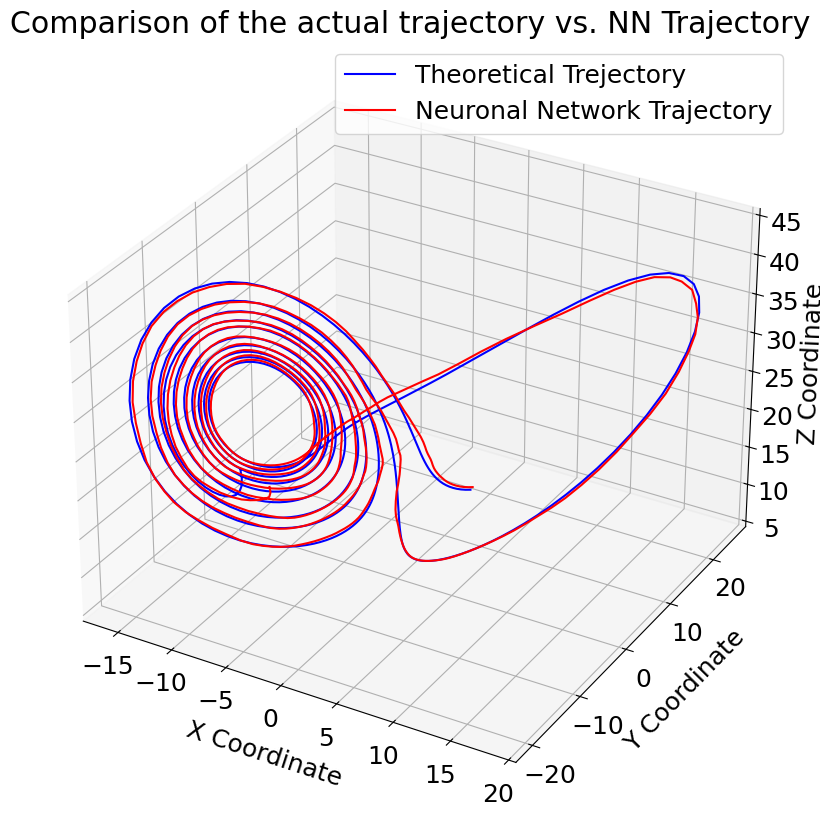

In [ ]:
#Planteo algunas trayectorias para estudiar el funcionamiento

#Le aplico el modelo a los datos de testeo
red_neuronal.eval()
with torch.no_grad():
  resultados_test=red_neuronal(x_test_1)

#Deshago la transformacion
resultados_test=resultados_test.numpy()
resultados_test=scaler_y.inverse_transform(resultados_test.reshape(-1,3)).reshape(resultados_test.shape)

#Extraigo los datos correspondientes a la trayectoria real
x_real=y_comprobacion[0,:,0]
y_real=y_comprobacion[0,:,1]
z_real=y_comprobacion[0,:,2]

#Ajusto las dimensiones de los resultados
resultados_test=resultados_test.reshape(y_dimension)

#Extraigo los datos de la trayectoria a dibujar
x_pred=resultados_test[0,:,0]
y_pred=resultados_test[0,:,1]
z_pred=resultados_test[0,:,2]

#Dibujo la trayectoria teórica y la predicha por el modelo

fig=plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)
ax=fig.add_subplot(111, projection='3d')

ax.plot(x_real,y_real,z_real, label='Theoretical Trejectory', color='blue')

ax.plot(x_pred,y_pred,z_pred, label='Neuronal Network Trajectory', color='red')

ax.set_xlabel('X Coordinate',labelpad=12)
ax.set_ylabel('Y Coordinate',labelpad=12)
ax.set_zlabel('Z Coordinate',labelpad=5)
ax.set_title('Comparison of the actual trajectory vs. NN Trajectory')
ax.legend()
plt.show()

In [ ]:
#Planteo ahora una red RNN

class modelo_2(nn.Module):
  def __init__(self):
        super(modelo_2, self).__init__()
        self.rnn1=nn.RNN(3,62,batch_first=True,num_layers=1)
        self.fc=nn.Linear(62,62)
        self.fc2=nn.Linear(62,3)

  def forward(self, x):
        #Hacemos que los datos pasen a traves de nuestra red
        x,_=self.rnn1(x)
        x=torch.relu(x)
        x=self.fc(x)
        x=torch.relu(x)
        x=self.fc2(x)
        return x

red_RNN=modelo_2()

In [ ]:
#Planteo ahora el entrenamiento y la evaluación
epoca_2=100

#Genero tuplas dónde guardar las pérdidas
loss_ent_2=[]
loss_eval_2=[]
epocas_2=[]

#Optimizador
optimizador_2=optim.Adam(red_RNN.parameters(),lr=0.01)

for i in range(epoca_2):
  perdida_3,num_epoca_2=entrenamiento(i,red_RNN,optimizador_2,x_train_1,y_train_1)
  perdida_4=evaluacion(i,red_RNN,x_eval_1,y_eval_1)
  #Añado los valores a las tuplas
  loss_ent_2.append(perdida_3)
  loss_eval_2.append(perdida_4)
  epocas_2.append(num_epoca_2)

Training, Epoch: 1, Loss=1.0231077671051025
Evaluation, Epoch:1, Loss=0.8378681540489197
Training, Epoch: 2, Loss=0.8472066521644592
Evaluation, Epoch:2, Loss=0.6366214156150818
Training, Epoch: 3, Loss=0.633624792098999
Evaluation, Epoch:3, Loss=0.4646854102611542
Training, Epoch: 4, Loss=0.46097710728645325
Evaluation, Epoch:4, Loss=0.40250810980796814
Training, Epoch: 5, Loss=0.4071318805217743
Evaluation, Epoch:5, Loss=0.2647738754749298
Training, Epoch: 6, Loss=0.27392032742500305
Evaluation, Epoch:6, Loss=0.31334611773490906
Training, Epoch: 7, Loss=0.29848334193229675
Evaluation, Epoch:7, Loss=0.13933277130126953
Training, Epoch: 8, Loss=0.1455107480287552
Evaluation, Epoch:8, Loss=0.147077277302742
Training, Epoch: 9, Loss=0.14795713126659393
Evaluation, Epoch:9, Loss=0.16219264268875122
Training, Epoch: 10, Loss=0.15723168849945068
Evaluation, Epoch:10, Loss=0.12402521073818207
Training, Epoch: 11, Loss=0.12459196895360947
Evaluation, Epoch:11, Loss=0.08049403131008148
Trainin

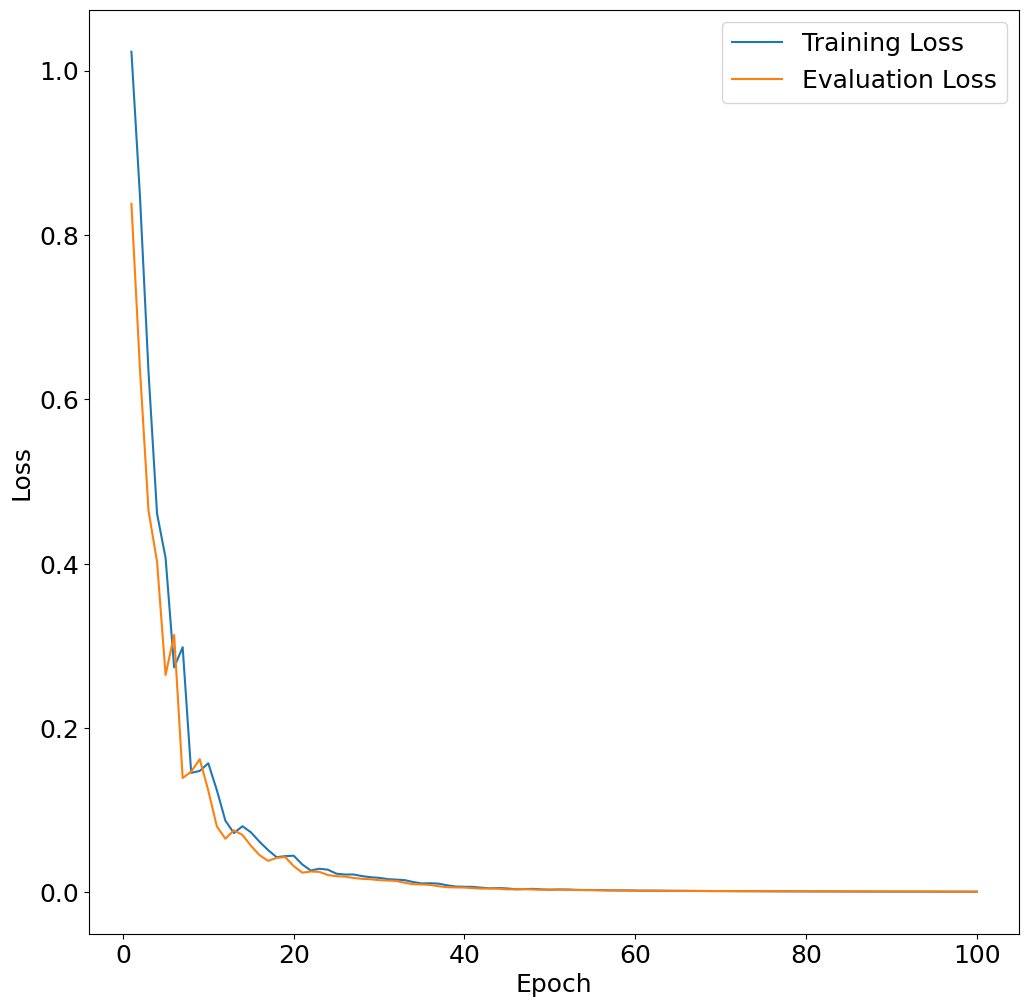

In [ ]:
#Dibujo ahora la función de pérdida del training y la evaluación

#Hago el plot
plt.plot(epocas_2,loss_ent_2,label='Training Loss')        #Plot para la pérdida del entrenamiento
plt.plot(epocas_2,loss_eval_2,label='Evaluation Loss')     #Plot para la pérdida de la evaluacion
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

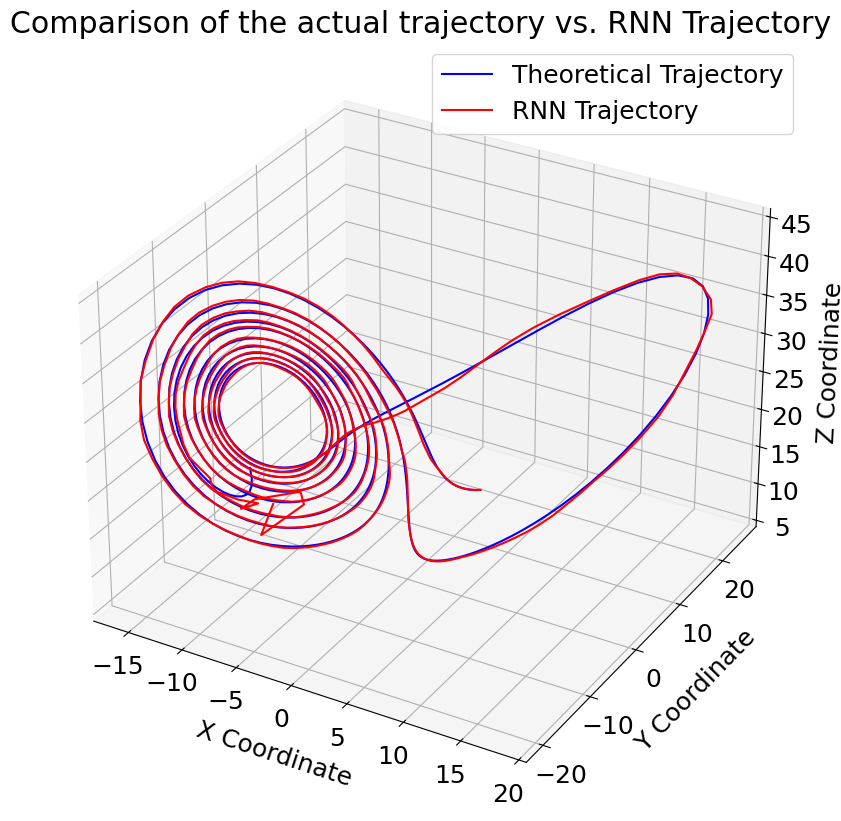

In [ ]:
#Planteo algunas trayectorias para estudiar el funcionamiento

#Le aplico el modelo a los datos de testeo
red_RNN.eval()
with torch.no_grad():
  resultados_test_2=red_RNN(x_test_1)

#Deshago la normalización de los datos
resultados_test_2=resultados_test_2.numpy()
resultados_test_2=scaler_y.inverse_transform(resultados_test_2.reshape(-1,3)).reshape(resultados_test_2.shape)

#Extraigo los datos correspondientes a la trayectoria real
x_real=y_comprobacion[0,:,0]
y_real=y_comprobacion[0,:,1]
z_real=y_comprobacion[0,:,2]

#Ajusto las dimensiones de los resultados
resultados_test_2=resultados_test_2.reshape(y_dimension)

#Extraigo los datos de la trayectoria a dibujar
x_pred_2=resultados_test_2[0,:,0]
y_pred_2=resultados_test_2[0,:,1]
z_pred_2=resultados_test_2[0,:,2]

#Dibujo la trayectoria teórica y la predicha por el modelo

fig=plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)
ax=fig.add_subplot(111, projection='3d')

ax.plot(x_real,y_real,z_real, label='Theoretical Trajectory', color='blue')

ax.plot(x_pred_2,y_pred_2,z_pred_2, label='RNN Trajectory', color='red')

ax.set_xlabel('X Coordinate',labelpad=12)
ax.set_ylabel('Y Coordinate',labelpad=12)
ax.set_zlabel('Z Coordinate',labelpad=9)
ax.set_title('Comparison of the actual trajectory vs. RNN Trajectory')
ax.legend()
plt.show()


In [ ]:
#Planteo la red LSTM

#Importo las librerías necesarias

class modelo_3(nn.Module):
  def __init__(self):
    super(modelo_3, self).__init__()
    #Incluyo ahora las diferentes capas
    self.LSTM_1=nn.LSTM(3,64,batch_first=True,num_layers=1)
    self.out=nn.Linear(64,64)
    self.out2=nn.Linear(64,3)

  def forward(self, x):
    #Hacemos que los datos pasen a traves de nuestra red
    x, _=self.LSTM_1(x)
    x=torch.tanh(x)
    x=self.out(x)
    x=torch.tanh(x)
    x=self.out2(x)
    return x

red_LSTM=modelo_3()

In [ ]:
#Entreno y evaluo el modelo
epoca_3=100

#Genero tuplas dónde guardar las pérdidas
loss_ent_3=[]
loss_eval_3=[]
epocas_3=[]

optimizador_3=optim.Adam(red_LSTM.parameters(),lr=0.015)

for i in range(epoca_3):
  perdida_5,num_epoca_3=entrenamiento(i,red_LSTM,optimizador_3,x_train_1,y_train_1)
  perdida_6=evaluacion(i,red_LSTM,x_eval_1,y_eval_1)
  #Añado los valores a las tuplas
  loss_ent_3.append(perdida_5)
  loss_eval_3.append(perdida_6)
  epocas_3.append(num_epoca_3)

Training, Epoch: 1, Loss=1.0293211936950684
Evaluation, Epoch:1, Loss=0.7732405662536621
Training, Epoch: 2, Loss=0.7938954830169678
Evaluation, Epoch:2, Loss=0.43488070368766785
Training, Epoch: 3, Loss=0.46083366870880127
Evaluation, Epoch:3, Loss=0.30047452449798584
Training, Epoch: 4, Loss=0.29701828956604004
Evaluation, Epoch:4, Loss=0.37588047981262207
Training, Epoch: 5, Loss=0.41155579686164856
Evaluation, Epoch:5, Loss=0.13214465975761414
Training, Epoch: 6, Loss=0.14441148936748505
Evaluation, Epoch:6, Loss=0.1859540194272995
Training, Epoch: 7, Loss=0.18201717734336853
Evaluation, Epoch:7, Loss=0.1905374825000763
Training, Epoch: 8, Loss=0.19209924340248108
Evaluation, Epoch:8, Loss=0.15258336067199707
Training, Epoch: 9, Loss=0.16432401537895203
Evaluation, Epoch:9, Loss=0.11161179840564728
Training, Epoch: 10, Loss=0.12885618209838867
Evaluation, Epoch:10, Loss=0.08907634764909744
Training, Epoch: 11, Loss=0.10187464207410812
Evaluation, Epoch:11, Loss=0.08941324800252914


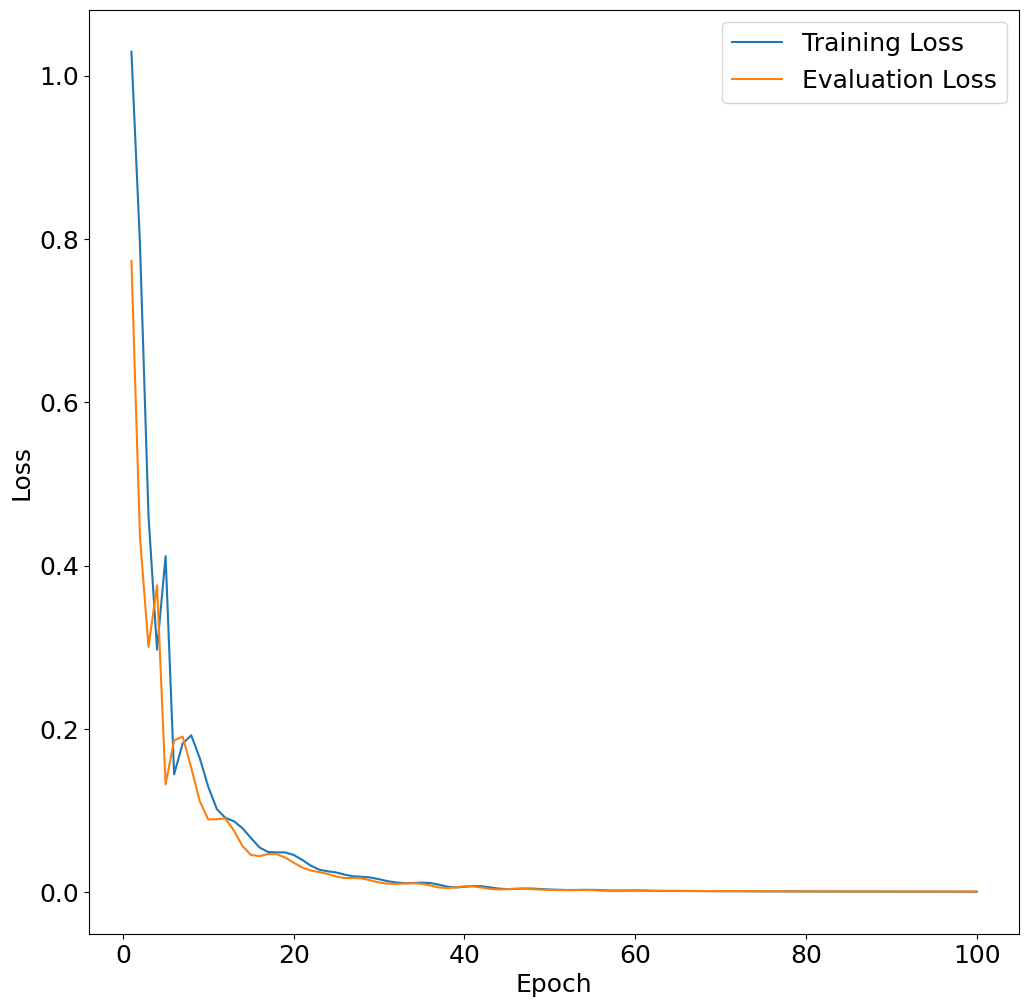

In [ ]:
#Dibujo ahora la función de pérdida del training y la evaluación

#Hago el plot
plt.plot(epocas_3,loss_ent_3,label='Training Loss')        #Plot para la pérdida del entrenamiento
plt.plot(epocas_3,loss_eval_3,label='Evaluation Loss')     #Plot para la pérdida de la evaluacion
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

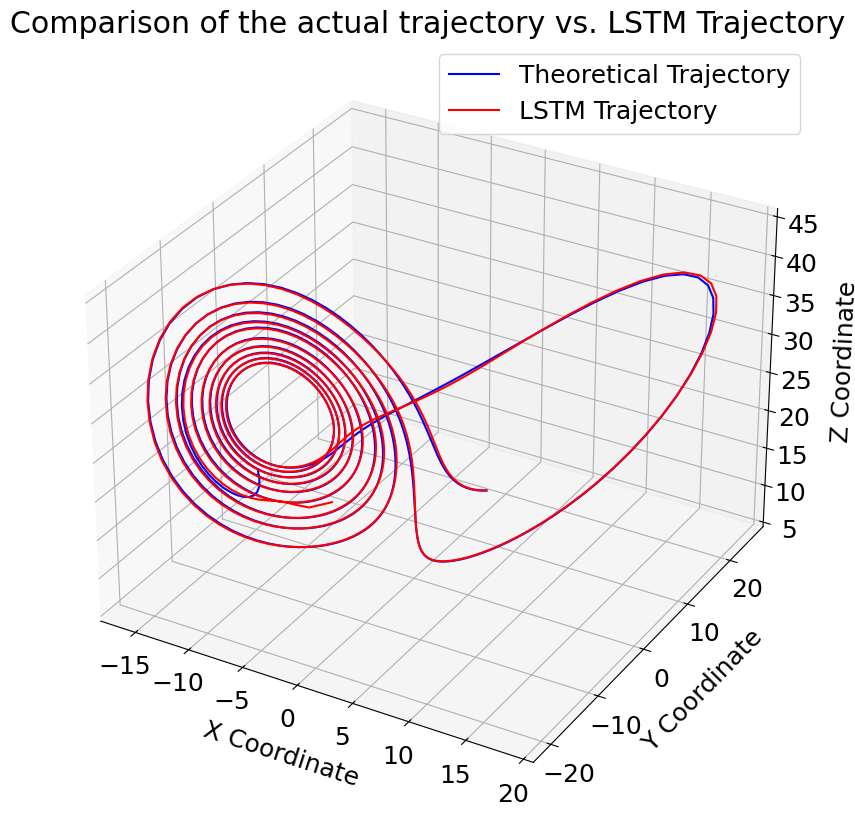

In [ ]:
#Estudio algunas trayectorias para ver el funcionamiento

#Le aplico el modelo a los datos de testeo
red_LSTM.eval()
with torch.no_grad():
  resultados_test_3=red_LSTM(x_test_1)

#Deshago la normalización
resultados_test_3=resultados_test_3.numpy()
resultados_test_3=scaler_y.inverse_transform(resultados_test_3.reshape(-1,3)).reshape(resultados_test_3.shape)

#Extraigo los datos correspondientes a la trayectoria real
x_real=y_comprobacion[0,:,0]
y_real=y_comprobacion[0,:,1]
z_real=y_comprobacion[0,:,2]

#Ajusto las dimensiones de los resultados
resultados_test_3=resultados_test_3.reshape(y_dimension)

#Extraigo los datos de la trayectoria a dibujar
x_pred_3=resultados_test_3[0,:,0]
y_pred_3=resultados_test_3[0,:,1]
z_pred_3=resultados_test_3[0,:,2]

#Dibujo la trayectoria teórica y la predicha por el modelo

fig=plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)
ax=fig.add_subplot(111, projection='3d')

ax.plot(x_real,y_real,z_real, label='Theoretical Trajectory', color='blue')

ax.plot(x_pred_3,y_pred_3,z_pred_3, label='LSTM Trajectory', color='red')

ax.set_xlabel('X Coordinate',labelpad=12)
ax.set_ylabel('Y Coordinate',labelpad=12)
ax.set_zlabel('Z Coordinate',labelpad=12)
ax.set_title('Comparison of the actual trajectory vs. LSTM Trajectory')
ax.legend()
plt.show()